<a href="https://colab.research.google.com/github/Ito-Santana/Machine_Learning_Projects/blob/main/Dogecoin_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Dogecoin Price Prediction

## What is dogecoin:

 Dogecoin is an open source peer-to-peer digital currency, favored by Shiba Inus worldwide. It is qualitatively more fun while being technically nearly identical to its close relative Bitcoin. This dataset contains its historical stock price in USD on a daily frequency starting from 17 September 2014.
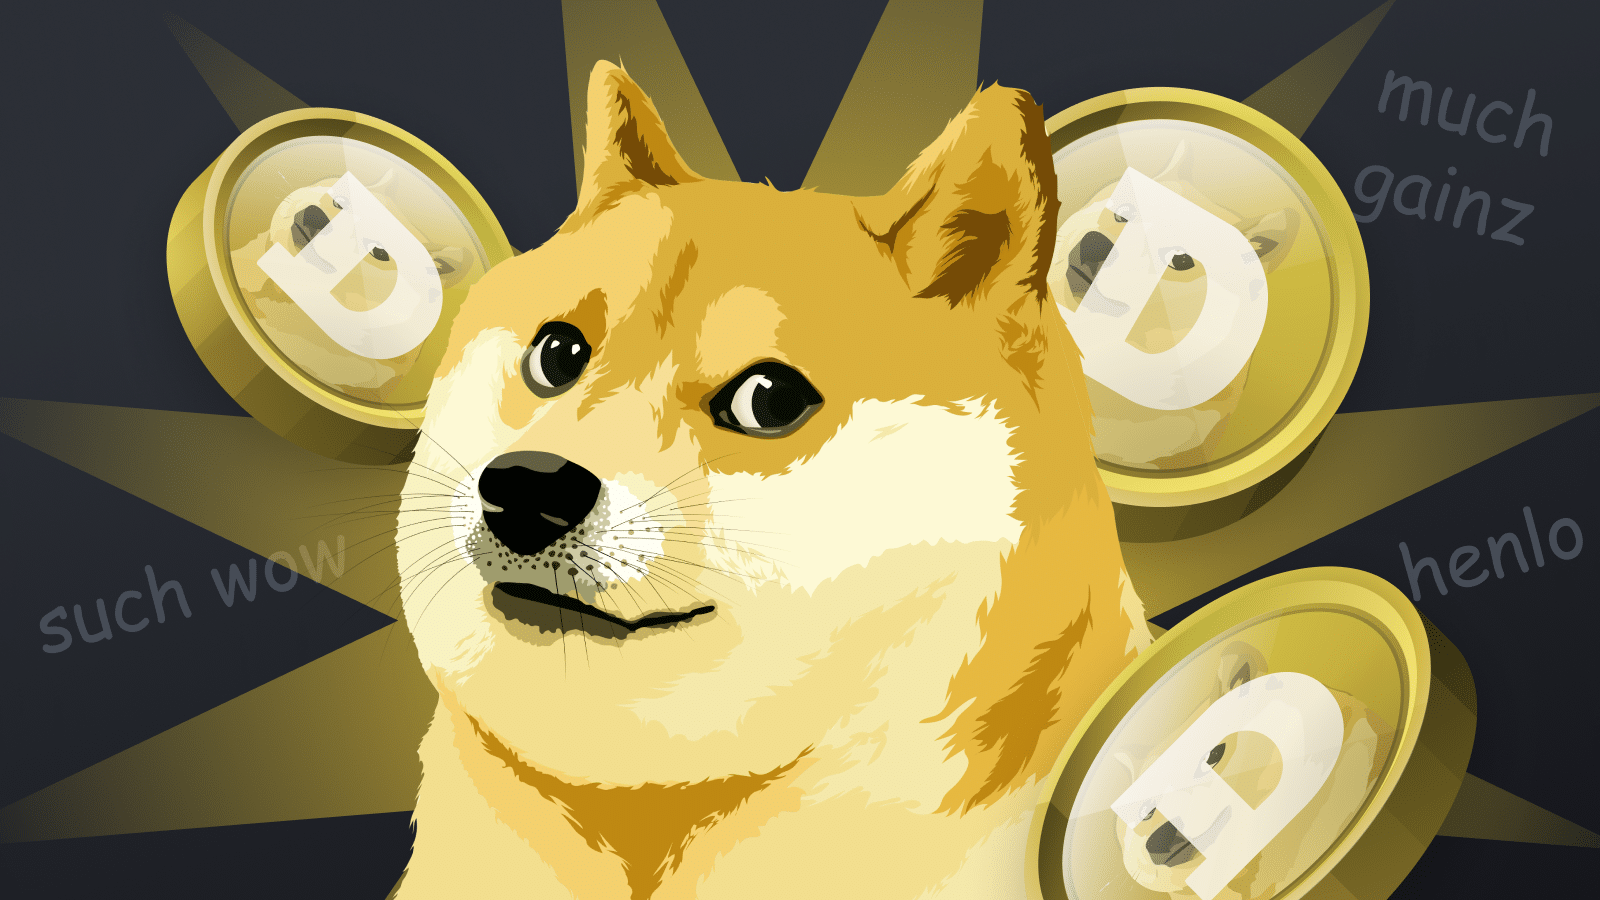


 ## About this project:

 The aim of this project is to predict the dogecoin's close price in order to make good decisions at the stock market.

#Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install optuna


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from plotly.subplots import make_subplots

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures,StandardScaler,MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, KFold

import optuna


In [ ]:
data=pd.read_csv('/content/drive/MyDrive/ML- projects/doge coin prediction/doge_usd.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-11-09,0.001207,0.001415,0.001181,0.001415,0.001415,6259550.0
1,2017-11-10,0.001421,0.001431,0.001125,0.001163,0.001163,4246520.0
2,2017-11-11,0.001146,0.001257,0.001141,0.001201,0.001201,2231080.0
3,2017-11-12,0.001189,0.001210,0.001002,0.001038,0.001038,3288960.0
4,2017-11-13,0.001046,0.001212,0.001019,0.001211,0.001211,2481270.0


#Data description

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2335 entries, 0 to 2334
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2335 non-null   object 
 1   Open       2334 non-null   float64
 2   High       2334 non-null   float64
 3   Low        2334 non-null   float64
 4   Close      2334 non-null   float64
 5   Adj Close  2334 non-null   float64
 6   Volume     2334 non-null   float64
dtypes: float64(6), object(1)
memory usage: 127.8+ KB




1.   We can see that date is an object dtype. Let's turn it into a datetime dtype.



In [ ]:
data.dropna(inplace=True)

In [ ]:
data['Date']=pd.to_datetime(data['Date'],format='%Y-%m-%d')
data['Date'].dtype

dtype('<M8[ns]')

In [ ]:
data.describe()

,Date,Open,High,Low,Close,Adj Close,Volume
count,2334,2334.000000,2334.000000,2334.000000,2334.000000,2334.000000,2.334000e+03
mean,2021-01-18 12:00:37.017995008,0.064848,0.068202,0.061686,0.064949,0.064949,9.501921e+08
min,2017-11-09 00:00:00,0.001046,0.001210,0.001002,0.001038,0.001038,1.431720e+06
25%,2019-06-15 06:00:00,0.002711,0.002801,0.002636,0.002715,0.002715,4.109104e+07
50%,2021-01-18 12:00:00,0.011040,0.013263,0.009794,0.011576,0.011576,1.893488e+08
75%,2022-08-24 18:00:00,0.083385,0.085707,0.080783,0.083509,0.083509,6.661201e+08
max,2024-03-31 00:00:00,0.687801,0.737567,0.608168,0.684777,0.684777,6.941068e+10
std,NaN,0.089241,0.096103,0.082657,0.089340,0.089340,3.149228e+09


The statistics for Close and Adj Close seem similar. It might be interesting to compare each value and return the percentage of equivalence.


In [ ]:
equal_values = data["Close"]== data['Adj Close']
print(f'the equivalence of Close e Adj. close is : {(equal_values.sum()/data["Close"].value_counts().sum()*100)}%')

the equivalence of Close e Adj. close is : 100.0%


If the equivalence was 100%, it indicates that the Close and Adj Close values were identical, meaning that Adj Close did not provide additional information beyond what Close already provided. Therefore, it would make sense to remove Adj Close from the model.

In [ ]:
data.drop('Adj Close',inplace=True,axis=1)


#Extracting Features


In [ ]:
data['Day']=data['Date'].apply(lambda x: x.day)
data['Month']=data['Date'].apply(lambda x : x.month)
data['Year']=data['Date'].apply(lambda x : x.year)

In [ ]:
data.head(1)

,Date,Open,High,Low,Close,Volume,Day,Month,Year
0,2017-11-09,0.001207,0.001415,0.001181,0.001415,6259550.0,9,11,2017


#EDA

## Close price x Date

In [ ]:
fig=px.line(data,x='Date',y='Close')
fig.show()

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



Basically the close price is constant between 2017 - 2021. So let's visualize this graph after 01/01/2021

In [ ]:
plt.figure(figsize = (16, 9))
filtered_data = data[data['Date'] >= '2021-01-01']
fig = px.line(filtered_data, x='Date', y='Close')
fig.show()

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



<Figure size 1600x900 with 0 Axes>

The close price has varied significantly over the past three years. I am particularly interested in identifying the peaks of maximum and minimum values during this period.



In [ ]:
max_value=filtered_data[['Close','Date']].sort_values('Close',ascending=False).head(1)
min_value=filtered_data[['Close','Date']].sort_values('Close',ascending=True).head(1)

print(f'The maximum close price was : \n{max_value}\n')
print(f'The minimum close price was : \n{min_value}')

The maximum close price was : 
         Close       Date
1275  0.684777 2021-05-07

The minimum close price was : 
         Close       Date
1149  0.005685 2021-01-01


As we can see, the maximum close price was in May, or more precisely 05/07/2021 and the minimum value was in 01/01/2021.



---



## Maybe it seems important to subdivide the data into four periods:

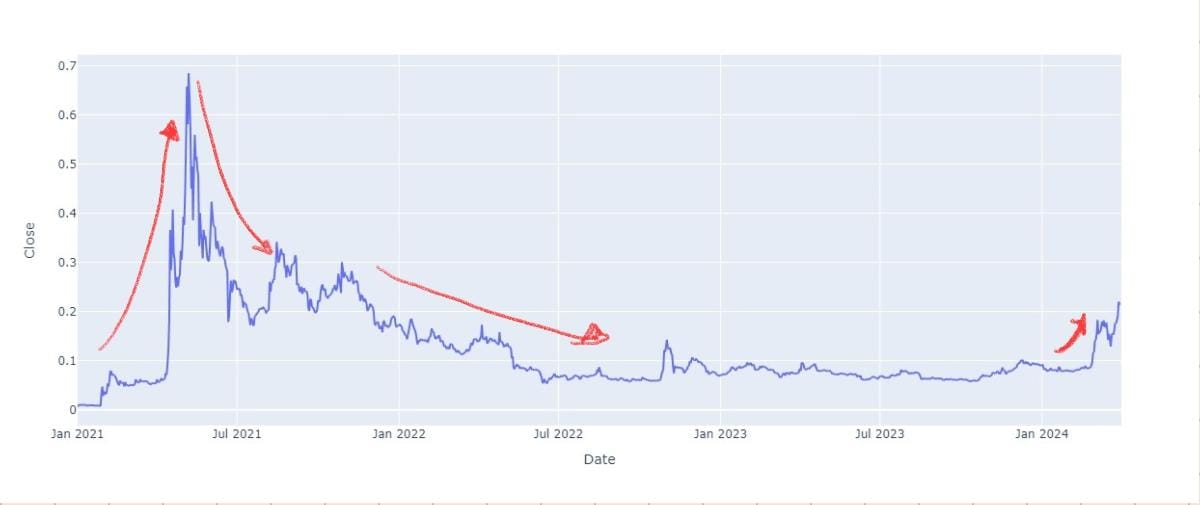


1. The ascending trend between February 2021 and May 2021
2. The descending trend between May 2021 and August 2021
3. The descending trend between October 2021 and October 2022
4. The ascending trend between January 2024 and March 2024



### 1. The ascending trend between January 2021 and May 2021:


In [ ]:
filtered_data = data[ (data['Date'] <= '2021-05-15') & (data['Date']>='2021-02-09' )]

filtered_data['Price variation'] = filtered_data.apply(lambda x: x['Open'] - x['Close'],axis=1)
fig1 = px.line(filtered_data, x='Date', y='Close')
fig2 = px.line(filtered_data, x='Date', y='Price variation')

fig=make_subplots(rows=2,cols=1,shared_xaxes=True,subplot_titles=('Close Price X Date','Price Variation x Date'))

for trace in fig1.data:
  fig.add_trace(trace,row=1,col=1)

for trace in fig2.data:
  fig.add_trace(trace,row=2,col=1)

fig.show()

num_pos_var = [k for k in filtered_data['Price variation'].values if k > 0]
num_neg_var = [k for k in filtered_data['Price variation'].values if k < 0]

var= sum(num_pos_var)+sum(num_neg_var)

print(f'We had {len(num_pos_var)} days with positive price variation; {len(num_neg_var)} days with negative price variation')
print(f'The variation during the period was {var}')



<ipython-input-228-6da9995167c4>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



We had 51 days with positive price variation; 45 days with negative price variation
The variation during the period was -0.44015899999999986


### 2. The descending trend between May 2021 and August 2021


In [ ]:
filtered_data = data[ (data['Date'] >= '2021-05-15') & (data['Date']<='2021-08-01' )]


filtered_data['Price variation'] = filtered_data.apply(lambda x: x['Open'] - x['Close'],axis=1)
fig1 = px.line(filtered_data, x='Date', y='Close')
fig2 = px.line(filtered_data, x='Date', y='Price variation')

fig=make_subplots(rows=2,cols=1,shared_xaxes=True,subplot_titles=('Close Price X Date','Price Variation x Date'))

for trace in fig1.data:
  fig.add_trace(trace,row=1,col=1)

for trace in fig2.data:
  fig.add_trace(trace,row=2,col=1)

fig.show()

num_pos_var = [k for k in filtered_data['Price variation'].values if k > 0]
num_neg_var = [k for k in filtered_data['Price variation'].values if k < 0]

var= sum(num_pos_var)+sum(num_neg_var)

print(f'We had {len(num_pos_var)} days with positive price variation; {len(num_neg_var)} days with negative price variation')
print(f'The variation during the period was {var}')



<ipython-input-229-16fff39c6c10>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



We had 46 days with positive price variation; 33 days with negative price variation
The variation during the period was 0.3351440000000001


### 3. The descending trend between October 2021 and October 2022


In [ ]:
filtered_data = data[ (data['Date'] >= '2021-10-28') & (data['Date']<='2022-10-28' )]


filtered_data['Price variation'] = filtered_data.apply(lambda x: x['Open'] - x['Close'],axis=1)
fig1 = px.line(filtered_data, x='Date', y='Close')
fig2 = px.line(filtered_data, x='Date', y='Price variation')

fig=make_subplots(rows=2,cols=1,shared_xaxes=True,subplot_titles=('Close Price X Date','Price Variation x Date'))

for trace in fig1.data:
  fig.add_trace(trace,row=1,col=1)

for trace in fig2.data:
  fig.add_trace(trace,row=2,col=1)

fig.show()

num_pos_var = [k for k in filtered_data['Price variation'].values if k > 0]
num_neg_var = [k for k in filtered_data['Price variation'].values if k < 0]

var= sum(num_pos_var)+sum(num_neg_var)

print(f'We had {len(num_pos_var)} days with positive price variation; {len(num_neg_var)} days with negative price variation')
print(f'The variation during the period was {var}')



<ipython-input-230-69bb593c4254>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



We had 191 days with positive price variation; 175 days with negative price variation
The variation during the period was 0.16534899999999997


In [ ]:
num_pos_var = [k for k in filtered_data['Price variation'].values if k > 0]
num_neg_var = [k for k in filtered_data['Price variation'].values if k < 0]

var= sum(num_pos_var)+sum(num_neg_var)

print(f'We had {len(num_pos_var)} days with positive price variation; {len(num_neg_var)} days with negative price variation')
print(f'The variation during the period was {var}')



We had 191 days with positive price variation; 175 days with negative price variation
The variation during the period was 0.16534899999999997


###4. The ascending trend between January 2024 and March 2024

In [ ]:
filtered_data = data[ (data['Date'] >= '2024-01-01') ]


filtered_data['Price variation'] = filtered_data.apply(lambda x: x['Open'] - x['Close'],axis=1)
fig1 = px.line(filtered_data, x='Date', y='Close')
fig2 = px.line(filtered_data, x='Date', y='Price variation')

fig=make_subplots(rows=2,cols=1,shared_xaxes=True,subplot_titles=('Close Price X Date','Price Variation x Date'))

for trace in fig1.data:
  fig.add_trace(trace,row=1,col=1)

for trace in fig2.data:
  fig.add_trace(trace,row=2,col=1)

fig.show()

num_pos_var = [k for k in filtered_data['Price variation'].values if k > 0]
num_neg_var = [k for k in filtered_data['Price variation'].values if k < 0]

var= sum(num_pos_var)+sum(num_neg_var)

print(f'We had {len(num_pos_var)} days with positive price variation; {len(num_neg_var)} days with negative price variation')
print(f'The variation during the period was {var}')



<ipython-input-232-b2d5e72276af>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



We had 41 days with positive price variation; 49 days with negative price variation
The variation during the period was -0.12776899999999997


## Correlation matrix

<Axes: >

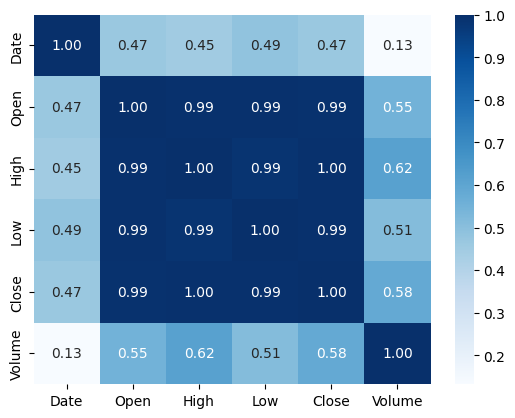

In [ ]:
corr=data.corr()
sns.heatmap(corr,cmap='Blues',fmt='.2f',annot=True)


Open, High, Low, and Close are correlated.

We need to see how they influence the model

#Data Preprocessing and Metrics Explanation

##Metrics:

1. Root Mean Squared Error (RMSE)

Definition: RMSE is a commonly used metric for evaluating the performance of regression models. It measures the square root of the average squared differences between the predicted and actual values.

Formula:
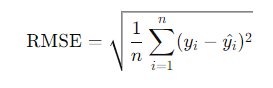

Why Use RMSE:

Sensitivity to Large Errors: RMSE gives more weight to large errors due to the squaring of differences. This makes it particularly useful when large errors are undesirable and need to be penalized more.
Scale-Dependent: RMSE is in the same units as the target variable, which makes it easy to interpret in the context of the data.
Comparison Across Models: It allows for straightforward comparison of the prediction errors between different models, assuming the units of measurement are consistent.


2. Mean Absolute Error (MAE)

Definition: MAE is another metric for evaluating regression models. It measures the average magnitude of errors in the predictions, without considering their direction.

Formula:

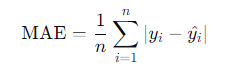

Why Use MAE:

Simplicity: MAE is simple to understand and interpret, as it provides the average absolute difference between the predicted and actual values.
Robust to Outliers: Unlike RMSE, MAE is less sensitive to outliers since it does not square the errors. This can be advantageous if the dataset contains noisy or anomalous data points.
Scale-Dependent: Like RMSE, MAE is in the same units as the target variable, making it easy to interpret.

## Best models :  

1. Linear Regression
2. Gradient Boosting Regressor

In [ ]:
data1=data.copy()

y=data1['Close']
X=data1.drop(columns=['Close','Date'])

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0,shuffle=True)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.3,random_state=0,shuffle=True)




## LinearRegression

In [ ]:
linear_pipe = Pipeline([
    ('model', LinearRegression())
])
linear_pipe.fit(X_train, y_train)


y_val_pred = linear_pipe.predict(X_val)


mse = mean_squared_error(y_val, y_val_pred)
mae=mean_absolute_error(y_val,y_val_pred)


print(f" Root Mean Squared Error on validation data: {mse**0.5}")
print(f"Mean Absolute Error on validation data : {mae}")


 Root Mean Squared Error on validation data: 0.006447376541860372
Mean Absolute Error on validation data : 0.001415778301146934


##Lasso

In [ ]:
pipe = Pipeline([

    ('model', Lasso())
])

pipe.fit(X_train, y_train)


y_val_pred =pipe.predict(X_val)


mse = mean_squared_error(y_val, y_val_pred)
mae=mean_absolute_error(y_val,y_val_pred)


print(f" Root Mean Squared Error on validation data: {mse**0.5}")
print(f"Mean Absolute Error on validation data : {mae}")

 Root Mean Squared Error on validation data: 0.0674934241315092
Mean Absolute Error on validation data : 0.05236327904667891


In [ ]:
standard_pipe = Pipeline([
    ("Scaler",StandardScaler()),
    ('model', Lasso())
])

standard_pipe.fit(X_train, y_train)


y_val_pred = standard_pipe.predict(X_val)


mse = mean_squared_error(y_val, y_val_pred)
mae=mean_absolute_error(y_val,y_val_pred)


print(f" Root Mean Squared Error on validation data: {mse**0.5}")
print(f"Mean Absolute Error on validation data : {mae}")

 Root Mean Squared Error on validation data: 0.08534415868104288
Mean Absolute Error on validation data : 0.06220759571892241


In [ ]:
minmax_pipe = Pipeline([
    ("Scaler",MinMaxScaler()),
    ('model', Lasso())
])

minmax_pipe.fit(X_train, y_train)


y_val_pred = minmax_pipe.predict(X_val)


mse = mean_squared_error(y_val, y_val_pred)
mae=mean_absolute_error(y_val,y_val_pred)


print(f" Root Mean Squared Error on validation data: {mse**0.5}")
print(f"Mean Absolute Error on validation data : {mae}")

 Root Mean Squared Error on validation data: 0.08534415868104288
Mean Absolute Error on validation data : 0.06220759571892241


## Ridge

In [ ]:
pipe = Pipeline([

    ('model', Ridge())

])

pipe.fit(X_train, y_train)


y_val_pred = pipe.predict(X_val)


mse = mean_squared_error(y_val, y_val_pred)
mae=mean_absolute_error(y_val,y_val_pred)


print(f" Root Mean Squared Error on validation data: {mse**0.5}")
print(f"Mean Absolute Error on validation data : {mae}")

 Root Mean Squared Error on validation data: 0.008603596760059883
Mean Absolute Error on validation data : 0.0038159991680565965


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning:

Ill-conditioned matrix (rcond=5.47008e-23): result may not be accurate.



In [ ]:
standard_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Ridge())
])

standard_pipe.fit(X_train, y_train)

y_val_pred = standard_pipe.predict(X_val)

mse = mean_squared_error(y_val, y_val_pred)
mae = mean_absolute_error(y_val, y_val_pred)

print(f"Root Mean Squared Error on validation data: {mse**0.5}")
print(f"Mean Absolute Error on validation data: {mae}")

Root Mean Squared Error on validation data: 0.005758786405652075
Mean Absolute Error on validation data: 0.001457989870243489


In [ ]:
minmax_pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('model', Ridge())
])

minmax_pipe.fit(X_train, y_train)

y_val_pred = minmax_pipe.predict(X_val)

mse = mean_squared_error(y_val, y_val_pred)
mae = mean_absolute_error(y_val, y_val_pred)

print(f"Root Mean Squared Error on validation data: {mse**0.5}")
print(f"Mean Absolute Error on validation data: {mae}")

Root Mean Squared Error on validation data: 0.0069963363644251235
Mean Absolute Error on validation data: 0.0024151716573875734


## KNeighborsRegressor

In [ ]:
pipe = Pipeline([
    ('model', KNeighborsRegressor())
])

pipe.fit(X_train, y_train)


y_val_pred = pipe.predict(X_val)


mse = mean_squared_error(y_val, y_val_pred)
mae=mean_absolute_error(y_val,y_val_pred)


print(f" Root Mean Squared Error on validation data: {mse**0.5}")
print(f"Mean Absolute Error on validation data : {mae}")

 Root Mean Squared Error on validation data: 0.048011966646406126
Mean Absolute Error on validation data : 0.02540011622103387


In [ ]:
standard_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', KNeighborsRegressor())
])

standard_pipe.fit(X_train, y_train)


y_val_pred = standard_pipe.predict(X_val)


mse = mean_squared_error(y_val, y_val_pred)
mae=mean_absolute_error(y_val,y_val_pred)


print(f" Root Mean Squared Error on validation data: {mse**0.5}")
print(f"Mean Absolute Error on validation data : {mae}")

 Root Mean Squared Error on validation data: 0.011251907043782627
Mean Absolute Error on validation data : 0.0025611622103386806


In [ ]:
minmax_pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('model', KNeighborsRegressor())
])

standard_pipe.fit(X_train, y_train)


y_val_pred = standard_pipe.predict(X_val)


mse = mean_squared_error(y_val, y_val_pred)
mae=mean_absolute_error(y_val,y_val_pred)


print(f" Root Mean Squared Error on validation data: {mse**0.5}")
print(f"Mean Absolute Error on validation data : {mae}")

 Root Mean Squared Error on validation data: 0.011251907043782627
Mean Absolute Error on validation data : 0.0025611622103386806


##SVR

In [ ]:
pipe = Pipeline([
    ('model', SVR())
])

pipe.fit(X_train, y_train)


y_val_pred = pipe.predict(X_val)


mse = mean_squared_error(y_val, y_val_pred)
mae=mean_absolute_error(y_val,y_val_pred)


print(f" Root Mean Squared Error on validation data: {mse**0.5}")
print(f"Mean Absolute Error on validation data : {mae}")

 Root Mean Squared Error on validation data: 0.07139580395243285
Mean Absolute Error on validation data : 0.06046081383900297


In [ ]:
standard_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', SVR())
])

standard_pipe.fit(X_train, y_train)


y_val_pred = standard_pipe.predict(X_val)


mse = mean_squared_error(y_val, y_val_pred)
mae=mean_absolute_error(y_val,y_val_pred)


print(f" Root Mean Squared Error on validation data: {mse**0.5}")
print(f"Mean Absolute Error on validation data : {mae}")

 Root Mean Squared Error on validation data: 0.08773346214105339
Mean Absolute Error on validation data : 0.08563692982038688


In [ ]:
minmax_pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('model', SVR())
])

standard_pipe.fit(X_train, y_train)


y_val_pred = standard_pipe.predict(X_val)


mse = mean_squared_error(y_val, y_val_pred)
mae=mean_absolute_error(y_val,y_val_pred)


print(f" Root Mean Squared Error on validation data: {mse**0.5}")
print(f"Mean Absolute Error on validation data : {mae}")

 Root Mean Squared Error on validation data: 0.08773346214105339
Mean Absolute Error on validation data : 0.08563692982038688


## GradientBoostingRegressor

In [ ]:
pipe = Pipeline([
    ('model', GradientBoostingRegressor())
])

pipe.fit(X_train, y_train)


y_val_pred = pipe.predict(X_val)


mse = mean_squared_error(y_val, y_val_pred)
mae=mean_absolute_error(y_val,y_val_pred)

print(f" Root Mean Squared Error on validation data: {mse**0.5}")
print(f"Mean Absolute Error on validation data : {mae}")

 Root Mean Squared Error on validation data: 0.00660521338204917
Mean Absolute Error on validation data : 0.0019956257454291065


In [ ]:
standard_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', GradientBoostingRegressor())
])

standard_pipe.fit(X_train, y_train)


y_val_pred = standard_pipe.predict(X_val)


mse = mean_squared_error(y_val, y_val_pred)
mae=mean_absolute_error(y_val,y_val_pred)


print(f" Root Mean Squared Error on validation data: {mse**0.5}")
print(f"Mean Absolute Error on validation data : {mae}")

 Root Mean Squared Error on validation data: 0.006644131031116583
Mean Absolute Error on validation data : 0.0019936738888495726


In [ ]:
minmax_pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('model', GradientBoostingRegressor())
])

standard_pipe.fit(X_train, y_train)


y_val_pred = standard_pipe.predict(X_val)


mse = mean_squared_error(y_val, y_val_pred)
mae=mean_absolute_error(y_val,y_val_pred)


print(f" Root Mean Squared Error on validation data: {mse**0.5}")
print(f"Mean Absolute Error on validation data : {mae}")

 Root Mean Squared Error on validation data: 0.006682626477383831
Mean Absolute Error on validation data : 0.0020031118975601145


## Cross-validation

In [ ]:
pipeline = Pipeline([
    ('model', LinearRegression())
])

kf = KFold(n_splits=5, shuffle=True, random_state=0)
scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
positive_mse_scores = -scores
rmse_scores = np.sqrt(positive_mse_scores)


print("RMSE Scores for each fold:", rmse_scores)
print("Mean RMSE:", np.mean(rmse_scores))


RMSE Scores for each fold: [0.00349646 0.00319782 0.00512566 0.00220461 0.00447791]
Mean RMSE: 0.0037004899584483697


In [ ]:
 pipeline = Pipeline([
    ('model', GradientBoostingRegressor())
])

kf = KFold(n_splits=5, shuffle=True, random_state=0)
scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
positive_mse_scores = -scores
rmse_scores = np.sqrt(positive_mse_scores)


print("RMSE Scores for each fold:", rmse_scores)
print("Mean RMSE:", np.mean(rmse_scores))


RMSE Scores for each fold: [0.00605905 0.00859071 0.00911075 0.00475842 0.00495921]
Mean RMSE: 0.006695627236093649


# LinearRegression - Tunning , Testing and Plotting

In [ ]:
linear=LinearRegression()

linear.fit(X_train,y_train)
y_val_pred = standard_pipe.predict(X_val)

mse = mean_squared_error(y_val, y_val_pred)
mae=mean_absolute_error(y_val,y_val_pred)


print(f" Root Mean Squared Error on validation data: {mse**0.5}")
print(f"Mean Absolute Error on validation data : {mae}")

 Root Mean Squared Error on validation data: 0.006682626477383831
Mean Absolute Error on validation data : 0.0020031118975601145


##Tunning hyperparams

In [ ]:
def objective(trial):

    degree = trial.suggest_int('degree', 1, 5)

    pipeline = Pipeline([
        ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
        ('regressor', LinearRegression())
    ])


    pipeline.fit(X_train, y_train)
    y_val_pred = pipeline.predict(X_val)


    mse = mean_squared_error(y_val, y_val_pred)
    mae = mean_absolute_error(y_val, y_val_pred)


    return mse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
best_trial = study.best_trial

print(f"Best Trial Number: {best_trial.number}")
print(f"Best Hyperparameters: {best_trial.params}")
print(f"Best Value (MSE): {best_trial.value}")



[I 2024-09-11 14:43:47,126] A new study created in memory with name: no-name-ecd283f7-729d-4b67-8bd3-94f8c396588d
[I 2024-09-11 14:43:47,154] Trial 0 finished with value: 0.0073254166249190796 and parameters: {'degree': 4}. Best is trial 0 with value: 0.0073254166249190796.
[I 2024-09-11 14:43:47,187] Trial 1 finished with value: 0.006715980877342281 and parameters: {'degree': 3}. Best is trial 1 with value: 0.006715980877342281.
[I 2024-09-11 14:43:47,228] Trial 2 finished with value: 0.0073254166249190796 and parameters: {'degree': 4}. Best is trial 1 with value: 0.006715980877342281.
[I 2024-09-11 14:43:47,854] Trial 3 finished with value: 0.0073254166249190796 and parameters: {'degree': 4}. Best is trial 1 with value: 0.006715980877342281.
[I 2024-09-11 14:43:47,916] Trial 4 finished with value: 4.156853120599691e-05 and parameters: {'degree': 1}. Best is trial 4 with value: 4.156853120599691e-05.
[I 2024-09-11 14:43:48,095] Trial 5 finished with value: 0.0073254166249190796 and pa

Best Trial Number: 4
Best Hyperparameters: {'degree': 1}
Best Value (MSE): 4.156853120599691e-05


## Testing

In [ ]:
best_degree = study.best_params['degree']


final_pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=best_degree, include_bias=False)),
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])


final_pipeline.fit(X_train, y_train)


y_test_pred = final_pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)

print(f"Root Mean Squared Error on validation data: {mse**0.5}")
print(f"Mean Absolute Error on validation data: {mae}")


Root Mean Squared Error on validation data: 0.003261642362250129
Mean Absolute Error on validation data: 0.0012648848680146588


##Plotting

In [ ]:
plotdata = pd.DataFrame({
    'Index': range(len(y_test)),
    'True Values': y_test,
    'Predictions': y_test_pred
})


fig = px.line(plotdata, x='Index', y=['True Values', 'Predictions'], title='True Values and Predictions Over Index')


fig.update_traces(line=dict(width=2))


fig.show()

# Importing Dogecoin Data from April 2024 to September 2024

It is important to highlight that this data was not included in the original dataset. This will serve as a crucial test of the model’s efficiency in predicting the closing prices.

In [ ]:
doge2024 = pd.read_csv('/content/drive/MyDrive/ML- projects/doge coin prediction/dogecoin -2024.csv')
doge2024=doge2024.drop(columns=['Dividends','Stock Splits'])

doge2024['Date'] = doge2024['Date'].str.split(' ').str[0]  # Remove tempo e fuso horário
doge2024['Date'] = pd.to_datetime(doge2024['Date'], format='%Y-%m-%d')

doge2024=doge2024.query('Date >= "2024-04-01"')


In [ ]:
x_doge=doge2024.drop(columns=['Close','Date'])
y_doge=doge2024['Close']
date=doge2024['Date']

In [ ]:
y_doge_pred = final_pipeline.predict(x_doge)

errors = y_doge - y_doge_pred
mse = mean_squared_error(y_doge, y_doge_pred)
mae = mean_absolute_error(y_doge, y_doge_pred)
rmse = mse**0.5
std_error = np.std(errors)


std_rmse = np.sqrt(np.var(errors**2))

print(f"Root Mean Squared Error on validation data: {rmse}")
print(f"Standard Deviation of RMSE: {std_rmse}")
print(f"Mean Absolute Error on validation data: {mae}")
print(f"Standard Deviation of errors: {std_error}")

Root Mean Squared Error on validation data: 0.0026047817376082657
Standard Deviation of RMSE: 1.2181641418951272e-05
Mean Absolute Error on validation data: 0.001982871310670109
Standard Deviation of errors: 0.0025532032065768468


In [ ]:
plotdata2024 = pd.DataFrame({
    'Date': date,
    'True Values': y_doge,
    'Predictions': y_doge_pred
})


In [ ]:
fig = px.line(plotdata2024, x='Date', y=['True Values', 'Predictions'], title='True Values and Predictions Over 2024')


fig.update_traces(line=dict(width=2))


fig.show()

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



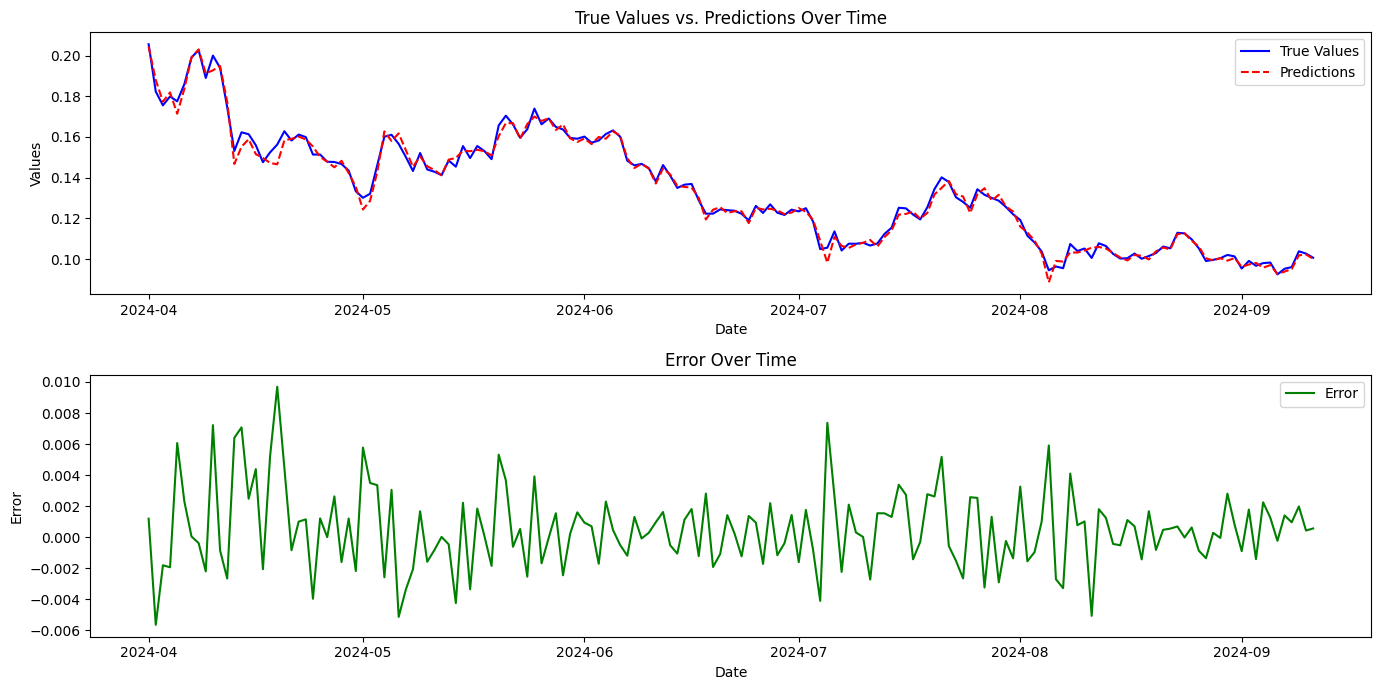

In [ ]:

plotdata2024['Date'] = pd.to_datetime(plotdata2024['Date'])

plotdata2024 = plotdata2024.sort_values(by='Date')


plotdata2024['Errors'] = plotdata2024['True Values'] - plotdata2024['Predictions']


plt.figure(figsize=(14, 7))


plt.subplot(2, 1, 1)
plt.plot(plotdata2024['Date'], plotdata2024['True Values'], label='True Values', color='blue')
plt.plot(plotdata2024['Date'], plotdata2024['Predictions'], label='Predictions', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('True Values vs. Predictions Over Time')
plt.legend()

# Plot errors
plt.subplot(2, 1, 2)
plt.plot(plotdata2024['Date'], plotdata2024['Errors'], label='Error', color='green')
plt.xlabel('Date')
plt.ylabel('Error')
plt.title('Error Over Time')
plt.legend()


plt.tight_layout()
plt.show()


## Investiment Strategy

###1. Moving Average Crossover
**Overview:** The Moving Average Crossover strategy uses two different moving averages to generate buy and sell signals based on their crossover points.

**How It Works:**

* Buy Signal: Generated when the short-term moving average (e.g., 10-day) crosses above the long-term moving average (e.g., 50-day). This indicates a potential upward trend.
* Sell Signal: Generated when the short-term moving average crosses below the long-term moving average, suggesting a possible downward trend.

**Implementation:**

* Calculate short-term and long-term moving averages of the asset price.
* Generate buy signals when the short-term average is greater than the long-term average.
* Generate sell signals when the short-term average is less than the long-term average.

**Pros:**

* Simple to implement and understand.
* Effective in trending markets.

**Cons:**

Can generate false signals in choppy or sideways markets.
May lag behind current market conditions due to the averaging process.

### 2. Momentum
**Overview:** The Momentum strategy capitalizes on the continuation of existing trends by investing in assets that are showing upward momentum and avoiding those with downward momentum.

**How It Works:**

* Buy Signal: Generated when the momentum (rate of change in the price) is positive, indicating a strong upward trend.
* Sell Signal: Generated when the momentum is negative, signaling a potential downward trend.

**Implementation:**

* Calculate the momentum of the asset price over a specific period (e.g., 14 days).
* Generate buy signals when momentum is positive.
* Generate sell signals when momentum is negative.

**Pros:**

* Can be effective in capturing strong trends.
* Simplicity in application.

**Cons:**

* May result in losses during trend reversals or when momentum is volatile.
* Can be less effective in sideways or consolidating markets.

###3. Mean Reversion
**Overview:** The Mean Reversion strategy is based on the principle that asset prices will tend to revert to their historical average over time. This strategy buys undervalued assets and sells overvalued ones.

**How It Works:**

* Buy Signal: Generated when the asset price is significantly below its historical average, suggesting it is undervalued and likely to rise.
* Sell Signal: Generated when the asset price is significantly above its historical average, indicating it may be overvalued and likely to fall.

**Implementation:**

* Calculate the rolling mean and standard deviation of the asset price over a period.
* Compute the Z-Score, which measures how far the price deviates from the mean in terms of standard deviations.
* Generate buy signals when the Z-Score is below a certain threshold (e.g., -2), and sell signals when the Z-Score is above a certain threshold (e.g., +2).

**Pros:**

* Useful for markets or assets that exhibit strong mean-reverting behavior.
* Can help identify overbought and oversold conditions.

**Cons:**

* May perform poorly in strongly trending markets where prices deviate significantly from the mean.
* Requires careful selection of parameters and thresholds.
### 4. Dynamic Allocation
**Overview:** The Dynamic Allocation strategy adjusts the proportion of the investment based on market conditions, particularly volatility. It aims to optimize returns while managing risk.

**How It Works:**

* Buy Signal: Generated when market volatility is low, suggesting a stable environment where the investment can be increased.
* Sell Signal: Generated when market volatility is high, indicating increased risk and prompting a reduction in investment.

**Implementation:**

* Calculate the rolling volatility of the asset price over a specified period (e.g., 20 days).
* Generate buy signals when the volatility is below its historical median, suggesting lower risk.
* Generate sell signals when volatility is above its historical median, indicating higher risk.

**Pros:**

* Allows for flexible risk management and adjustment based on current market conditions.
* Can help protect the investment during high-risk periods.

**Cons:**

* May result in frequent trading and associated transaction costs.
* Effectiveness depends on accurate volatility measurement and risk management.


In [ ]:
# Strategy 1: Moving Average Crossover
short_window = 10
long_window = 50

plotdata2024['Short_MA'] = plotdata2024['True Values'].rolling(window=short_window, min_periods=1).mean()
plotdata2024['Long_MA'] = plotdata2024['True Values'].rolling(window=long_window, min_periods=1).mean()
plotdata2024['Signal_MA'] = np.where(plotdata2024['Short_MA'] > plotdata2024['Long_MA'], 1, 0)
plotdata2024['Position_MA'] = plotdata2024['Signal_MA'].diff().fillna(0)

# Strategy 2: Momentum
momentum_period = 14
plotdata2024['Momentum'] = plotdata2024['True Values'].diff(momentum_period)
plotdata2024['Signal_Momentum'] = np.where(plotdata2024['Momentum'] > 0, 1, 0)

# Strategy 3: Mean Reversion
window = 20
threshold = 2

plotdata2024['Rolling_Mean'] = plotdata2024['True Values'].rolling(window=window).mean()
plotdata2024['Rolling_STD'] = plotdata2024['True Values'].rolling(window=window).std()
plotdata2024['Z_Score'] = (plotdata2024['True Values'] - plotdata2024['Rolling_Mean']) / plotdata2024['Rolling_STD']
plotdata2024['Signal_MeanReversion'] = np.where(plotdata2024['Z_Score'] < -threshold, 1, np.where(plotdata2024['Z_Score'] > threshold, -1, 0))

# Strategy 4: Dynamic Allocation
plotdata2024['Volatility'] = plotdata2024['True Values'].rolling(window=20).std()
plotdata2024['Signal_Volatility'] = np.where(plotdata2024['Volatility'] < plotdata2024['Volatility'].median(), 1, 0)

# Calculate returns and investment value for each strategy
strategies = ['MA', 'Momentum', 'MeanReversion', 'Volatility']
initial_investment = 1000

for strategy in strategies:
    if strategy == 'MA':
        signal_col = 'Signal_MA'
    elif strategy == 'Momentum':
        signal_col = 'Signal_Momentum'
    elif strategy == 'MeanReversion':
        signal_col = 'Signal_MeanReversion'
    elif strategy == 'Volatility':
        signal_col = 'Signal_Volatility'

    plotdata2024[f'{strategy}_Returns'] = plotdata2024['True Values'].pct_change().fillna(0)
    plotdata2024[f'{strategy}_Strategy_Returns'] = plotdata2024[f'{strategy}_Returns'] * plotdata2024[signal_col].shift(1).fillna(0)
    plotdata2024[f'{strategy}_Investment_Value'] = initial_investment * (1 + plotdata2024[f'{strategy}_Strategy_Returns']).cumprod()

    final_value = plotdata2024[f'{strategy}_Investment_Value'].iloc[-1]
    profit = final_value - initial_investment
    print(f"\nStrategy: {strategy}")
    print(f"Initial Value of the Investment: R${initial_investment}")
    print(f"Final Value of the Investment: R${final_value:.2f}")
    print(f"Profit: R${profit:.2f}")




Strategy: MA
Initial Value of the Investment: R$1000
Final Value of the Investment: R$611.06
Profit: R$-388.94

Strategy: Momentum
Initial Value of the Investment: R$1000
Final Value of the Investment: R$743.05
Profit: R$-256.95

Strategy: MeanReversion
Initial Value of the Investment: R$1000
Final Value of the Investment: R$1073.94
Profit: R$73.94

Strategy: Volatility
Initial Value of the Investment: R$1000
Final Value of the Investment: R$1041.91
Profit: R$41.91
